In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import line_search
plt.rcParams["figure.figsize"] = (20, 10)

EPS = 1e-6
MAX_EPOCH = 100000


def distance(x, y):
    return np.linalg.norm(x - y)


class Function:
    def __init__(self, function, grad, min_point=(0, 0)):
        self.call = function
        self.grad = grad
        self.min_point = min_point

    def __call__(self, point):
        return self.call(point)

    def grad(self, point): return self.grad(point)    


def make_point(x, y): return np.array((x, y))

def draw_function(f):
    t = np.linspace(-5, 5, 100)
    x, y = np.meshgrid(t, t)
    ax = plt.figure().add_subplot(projection='3d')
    ax.plot_surface(x, y, f((x, y)))

def draw_gradient(f, points):
    colors = ['b', 'g', 'm', 'c', 'orange']
    t = np.linspace(-5, 5, 100)
    X, Y = np.meshgrid(t, t)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.plot(f((points[:, 0], points[:, 1])), lw=2, color=colors[0], )
    ax1.grid()

    Z = f([X, Y])
    cp = ax2.contourf(X, Y, Z)
    fig.colorbar(cp)
    ax2.plot(points[:, 0], points[:, 1], 'o-', color='r')

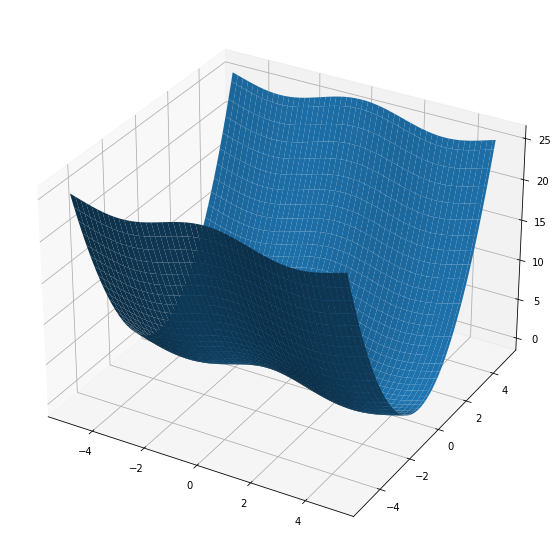

In [4]:
def cosy2(point):
    x, y = point
    return np.cos(x) + y ** 2


def grad_cosy2(point):
    x, y = point
    return make_point(-np.sin(x), 2 * y)


fun = Function(cosy2, grad_cosy2, np.array((math.pi, 0)))
draw_function(fun)

__Задание 1__

In [5]:
def abstract_gradient_descent(first_point, next_point_fun, stop_criteria):
    points = np.array([first_point])
    x = first_point
    epoch = 0
    while not stop_criteria(x) and epoch < MAX_EPOCH:
        x = next_point_fun(x, epoch)
        points = np.append(points, [x], axis=0)
        epoch += 1
    return points


def stop_by_grad(f):
    return lambda x: np.linalg.norm(f.grad(x)) < EPS


def lin_rate_grad_descent(f, first_point, lin_rate):
    next_point = lambda x, epoch: x - lin_rate(epoch) * np.array(f.grad(x))
    return abstract_gradient_descent(first_point, next_point, stop_by_grad(f))

Посмотрим, за сколько шагов наш градиентный спуск приходит к минимуму в зависимости от параметра linear_rate

In [6]:
def test_const_lin_rate(f, first_point, grad_descent, test_list):
    def run(lr):
        return grad_descent(f, first_point, lambda _: lr)

    ans = pd.DataFrame()
    ans["Linear rate"] = test_list
    ans["Epochs"] = list(map(len, map(run, test_list)))
    return ans


lin_rate_test_list = list(i for i in np.arange(0.2, 1, 0.1))
test_const_lin_rate(fun, make_point(2, 1), lin_rate_grad_descent, lin_rate_test_list)

,Linear rate,Epochs
0,0.2,65
1,0.3,41
2,0.4,29
3,0.5,22
4,0.6,17
5,0.7,17
6,0.8,30
7,0.9,67


__Задание 2__

In [5]:
def exp_lin_rate_grad_descent(f, first_point, d):
    return lin_rate_grad_descent(f, first_point, lambda epoch: np.exp(-d * epoch))


def test_exp_lin_rate(f, first_point, test_list):
    def run(d):
        return exp_lin_rate_grad_descent(f, first_point, d)

    ans = pd.DataFrame()
    ans["d"] = test_list
    ans["Epochs"] = list(map(len, map(run, test_list)))
    return ans


exp_lin_rate_test_list = list(i for i in np.arange(0.05, 0.10, 0.005))
test_exp_lin_rate(fun, make_point(2, 1), exp_lin_rate_test_list)

,d,Epochs
0,0.050,15
1,0.055,15
2,0.060,14
3,0.065,13
4,0.070,12
5,0.075,12
6,0.080,13
7,0.085,14
8,0.090,15
9,0.095,17


__Задание 3__
Улучшим наш градиентный спуск с помощью дихотомии:

12

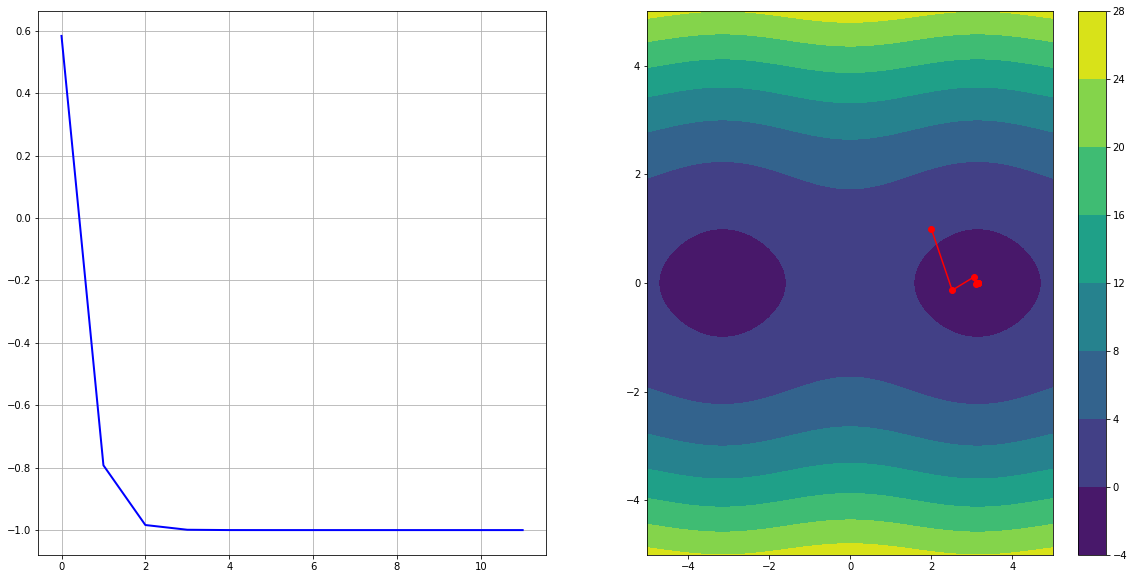

In [6]:
def dichotomy_constructor(left_bound, right_bound, delta, dichotomy_map=lambda x: x):
    def dichotomy(f):
        left = left_bound
        right = right_bound
        x = left
        while right - left >= EPS:
            x = (left + right) / 2
            if f(x - delta) <= f(x + delta):
                right = x
            else:
                left = x
        return dichotomy_map(x)

    return dichotomy


def dichotomy_grad_descent_constructor(left_bound, right_bound, delta):
    def impl(f, first_point):
        dichotomy = dichotomy_constructor(left_bound, right_bound, delta)

        def next_point_fun(x, epoch):
            d = dichotomy(lambda a: f(x - a * f.grad(x)))
            return x - d * f.grad(x)

        return abstract_gradient_descent(first_point, next_point_fun, stop_by_grad(f))

    return impl


dichotomy_grad_descent = dichotomy_grad_descent_constructor(-1, 1, 0.02)
ps = dichotomy_grad_descent(fun, make_point(2, 1))
draw_gradient(fun, ps)
len(ps)

In [7]:
t = fun.grad(make_point(2, 1)) ** 2
np.dot(t, t)

16.68363430620573

__Задание 4__
Применим к полученному алгоритму усиленные условия Вольфе  
  
![alt text](Wolphe.png)    
  
Первое неравенство отвечает за уменьшение функции после совершения шага, второе неравенство -- за уменьшение проекции градиента по модулю, чтобы не допустить точек далеких от стационарных  
Как правило : $c_1 = 0.0001$, $c_2 = 0.9$


12

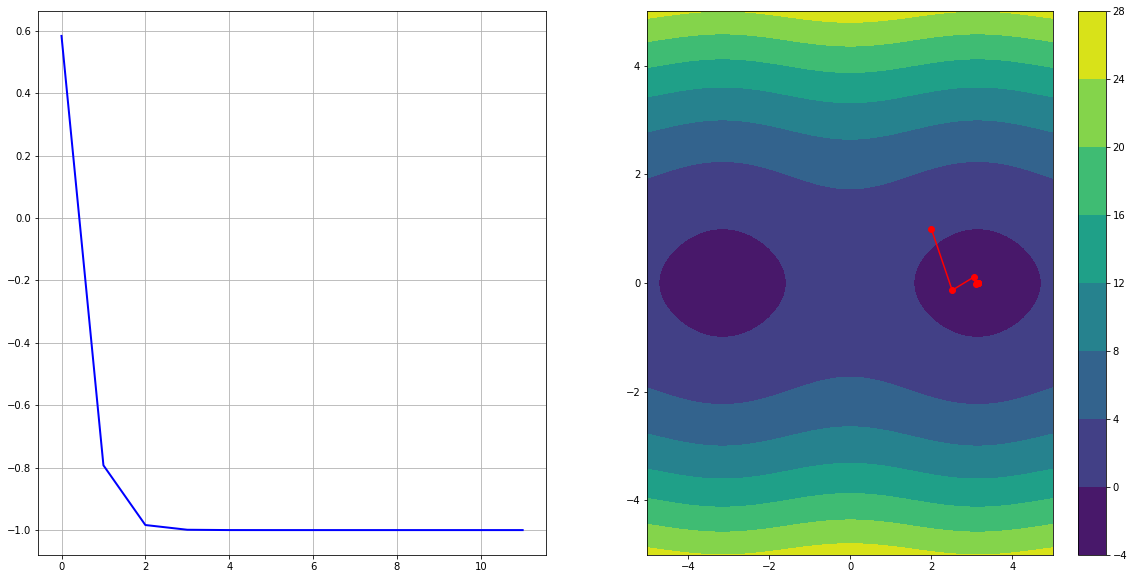

In [8]:
def Wolfe_grad_descent_constructor(left_bound, right_bound, delta):
    def impl(f, first_point):
        def next_point_fun(x, epoch):
            def check_Wolfe(alpha):
                fun_grad = f.grad(x)
                return (f(x - alpha * fun_grad) <= f(x) - C1 * alpha * np.dot(fun_grad, fun_grad) and
                        np.dot(f.grad(x - alpha * fun_grad), fun_grad) <= C2 * np.dot(fun_grad, fun_grad))

            def Wolphe_map(alpha):
                eps = 0
                global C1 
                C1 = 1e-4
                global C2
                C2 = 0.9
                for i in range(MAX_EPOCH):
                    alpha_left = alpha - eps
                    alpha_right = alpha + eps
                    if check_Wolfe(alpha_right):
                        return alpha_right
                    if check_Wolfe(alpha_left):
                        return alpha_left
                    else:
                        eps = eps + 0.001 if eps == 0 else eps * 2

            dichotomy = dichotomy_constructor(left_bound, right_bound, delta, dichotomy_map=Wolphe_map)


            d = dichotomy(lambda a: f(x - a * f.grad(x)))
            return x - d * f.grad(x)

        return abstract_gradient_descent(first_point, next_point_fun, stop_by_grad(f))

    return impl


Wolfe_grad_descent = Wolfe_grad_descent_constructor(-1, 1, 0.02)
ps = Wolfe_grad_descent(fun, make_point(2, 1))
draw_gradient(fun, ps)
len(ps)

__Задание 5__

In [9]:
def test_func(func):
    draw_function(func)
    common_lin_rate = 0.55
    points = lin_rate_grad_descent(fun1, make_point(4.5, 0), lambda _: common_lin_rate)
    draw_gradient(func, points)
    print('number of points:', len(points))


number of points: 39
number of points: 39


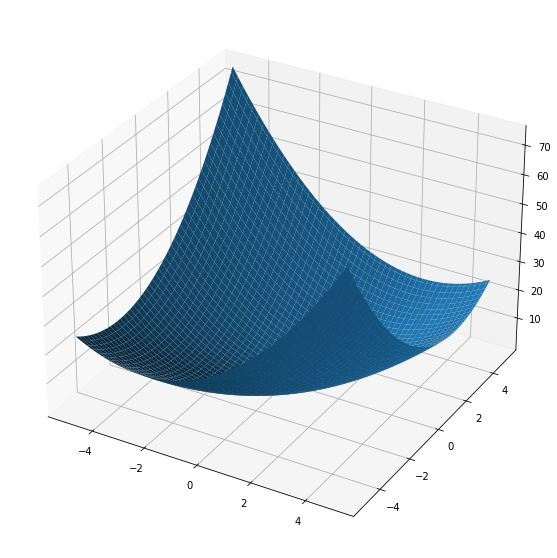

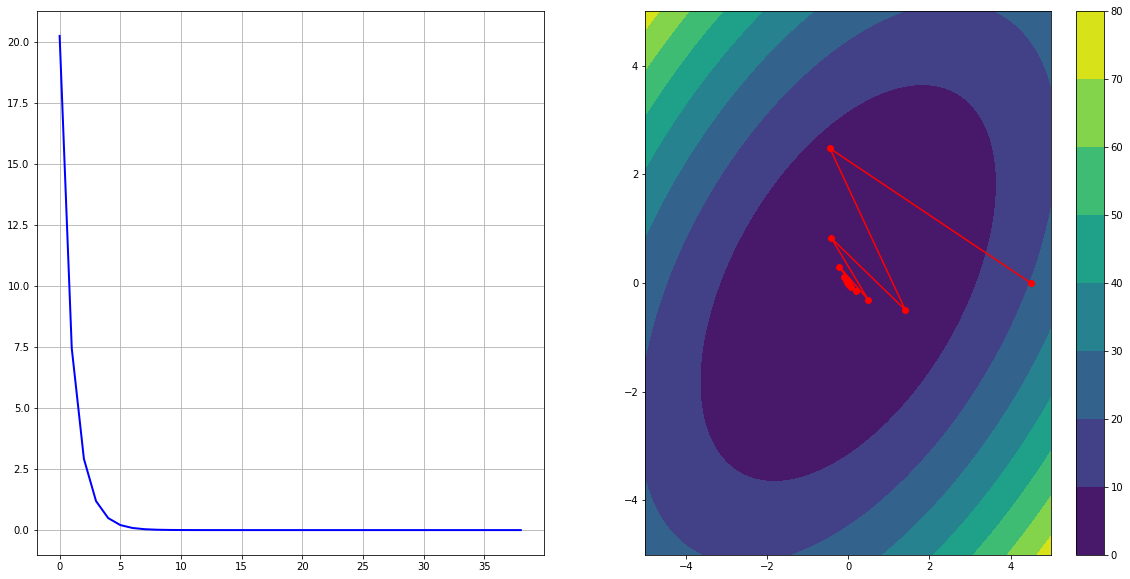

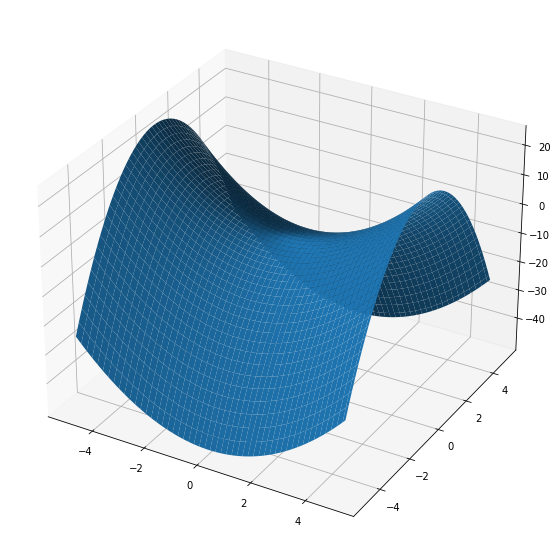

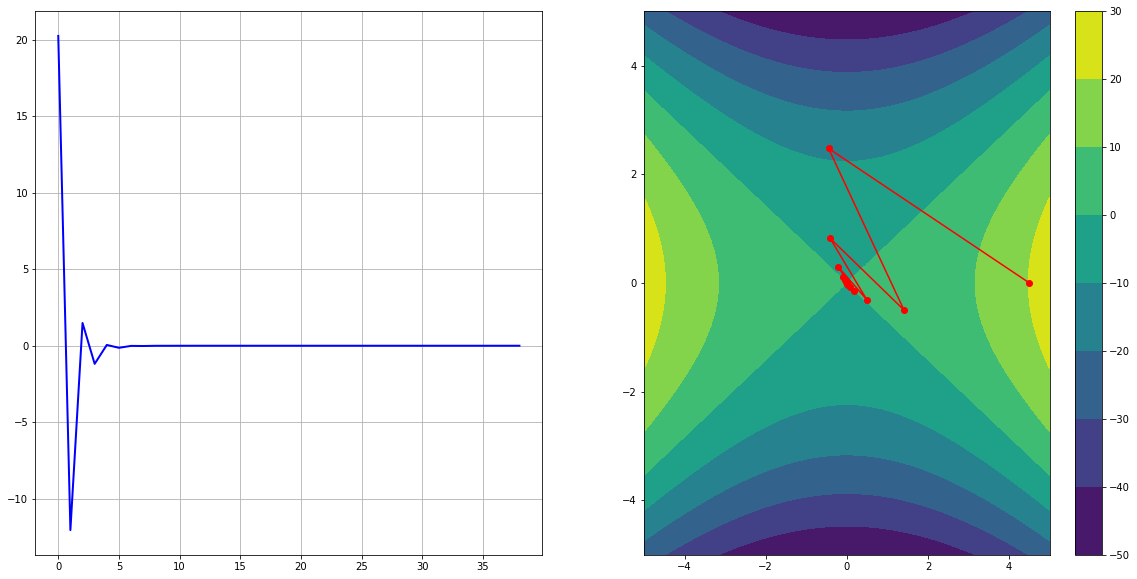

In [10]:
def func1(point):
    x, y = point
    return x**2 + y**2 - x * y
def grad1(point):
    x, y = point
    return make_point(2*x - y, 2*y - x)
fun1 = Function(func1, grad1, np.array((0, 0)))

test_func(fun1)


def func2(point):
    x, y = point
    return x**2 - 2 * y**2

def grad2(point):
    x, y = point
    return make_point(2*x, -4*y)
fun2 = Function(func2, grad2, np.array((0, 0)))

test_func(fun2)

In [11]:
lin_rate_test_list = np.arange(0.1, 0.7, 0.05)
test_const_lin_rate(fun1, make_point(4.5, 0), lin_rate_grad_descent, lin_rate_test_list)

,Linear rate,Epochs
0,0.10,144
1,0.15,94
2,0.20,69
3,0.25,54
4,0.30,43
5,0.35,36
6,0.40,31
7,0.45,27
8,0.50,25
9,0.55,39


In [12]:
test_const_lin_rate(fun2, make_point(4.5, 0), lin_rate_grad_descent, lin_rate_test_list)

,Linear rate,Epochs
0,0.10,73
1,0.15,46
2,0.20,33
3,0.25,25
4,0.30,19
5,0.35,15
6,0.40,11
7,0.45,8
8,0.50,2
9,0.55,8


<h2>Лабораторная №2, стохастический градиентный спуск</h2>

<h5>Задание 1</h5>

In [52]:
import random
from enum import Enum

def get_average_value(array):
    return np.mean(array)

def get_deviation(array):
    return np.std(array)

def get_normalized_points(array):
    average =  get_average_value(array)
    deviation =  get_deviation(array)
    return np.array([(x - average) / deviation for x in array])

class Mode(Enum):
     POINTS_ON_LINE = 1
     RANDOM_POINTS = 2

class Linear_Regression:
    def __init__(self, fr : int, to : int, mode : Mode, is_normalized : bool, number : int):
        self.painter = Draw(fr, to, is_normalized)
        if mode == Mode.POINTS_ON_LINE:
            points_array = self.painter.draw_line_points(number, 2, 1);
        else: 
            points_array = self.painter.draw_random_points(number)        
        self.points = np.stack(points_array, axis = 1)
        tmp_array = np.array([point[0] for point in self.points])
        self.average_x = get_average_value(tmp_array)
        self.deviation_x = get_deviation(tmp_array)
        self.gradients = []
        for point in self.points:
            self.gradients.append(Linear_Regression.create_gradient(point))     
        self.func = lambda linear: sum((linear[0] * point[0] + 
        linear[1] - point[1]) ** 2 for point in self.points)

    def __call__(self, point):
        self.func(point)        
        
    @staticmethod
    def create_gradient(point):
        x, y = point
        def func(point_):
            a, b = point_
            return [2 * (a * x + b - y) * x, 2 * (a * x + b - y)]
        return func    

    def sample_gradient(self, n):
        def grad_selected(point):
            grad = np.array((0, 0)) 
            selected = random.sample(self.gradients, k=n)
            for selection in selected:
                grad = grad + selection(point)
            return grad
        return grad_selected

    def get_Function(self, n):
        return Function(self.func, self.sample_gradient(n), make_point(0, 0))

    def get_points_number(self):
        return len(self.points)

    def get_full_Function(self):
        return Function(self.func, self.sample_gradient(self.get_points_number()), make_point(0, 0))    
    def stoch_grad_descent(self, fun, first_point, lin_rate_test_list):
        lines = []
        for lr in lin_rate_test_list:
            k, m = lin_rate_grad_descent(fun, first_point, lambda _: lr)[-1] 
            self.painter.draw_straight_line(k, m, self.average_x, self.deviation_x)
            lines.append(make_point(k, m))
        return (lines, test_const_lin_rate(fun, first_point, lin_rate_grad_descent, lin_rate_test_list)["Epochs"])    

    def test_stoch_grad(self, first_point, lin_rate_test_list):    
        fun = linear.get_Function(1) # use 1 summand to count gradient
        return self.stoch_grad_descent(fun, first_point, lin_rate_test_list)

    def test_minibatch(self, first_point, lin_rate_test_list, k):
        assert 2 <= k < linear.get_points_number() 
        fun = linear.get_Function(k) 
        return self.stoch_grad_descent(fun, first_point, lin_rate_test_list)

    def test_grad(self, first_point, lin_rate_test_list):
        fun = self.get_Function(linear.get_points_number())
        return self.stoch_grad_descent(fun, first_point, lin_rate_test_list)

    def get_table(self, first_point, lin_rate_test_list, num_minibatch):
        full_fun = self.get_full_Function()
        ans = pd.DataFrame()
        ans["Linear rate"] = lin_rate_test_list
        SGD_lines, SGD_epochs = self.test_stoch_grad(first_point, lin_rate_test_list)
        minibatch_lines, minibatch_epochs = self.test_minibatch(first_point, lin_rate_test_list, num_minibatch)
        GD_lines, GD_epochs = self.test_grad(first_point, lin_rate_test_list)
        ans["SGD distance"] = apply_fun(full_fun, SGD_lines)
        ans["minibatch distance"] = apply_fun(full_fun, minibatch_lines)
        ans["GD distance"] = apply_fun(full_fun, GD_lines)
        ans["SGD epochs"] = SGD_epochs
        ans["minibatch epochs"] = minibatch_epochs
        ans["GD epochs"] = GD_epochs
        return ans
        
    def show(self):
        self.painter()    

class Draw:
    def __init__(self, fr : float, to : float, is_normalized : bool):
        self.fr = fr
        self.to = to
        self.is_normalized = is_normalized

    def __call__(self):
        plt.show()      

    def draw_straight_line(self, k : float, m : float, average : float, deviation : float):
        x = np.linspace(self.fr, self.to)
        if self.is_normalized:
            m -= k * average / deviation
            k /= deviation
        y = k*x + m    
        plt.plot(x, y)

    def draw_random_points(self, number):
        x = np.random.uniform(self.fr, self.to, number) 
        y = np.random.uniform(self.fr, self.to, number)
        plt.scatter(x, y)  
        if self.is_normalized:
            x = get_normalized_points(x)
        return x, y
        
    def draw_line_points(self, number : int, k : float, m : float):
        x = np.random.uniform(self.fr, self.to, number)
        y = k*x + m 
        plt.scatter(x, y)
        if self.is_normalized:
            x = get_normalized_points(x)
        y = k*x + m    
        return x, y                      
        
def specify_EPS(eps):
        global EPS
        EPS = eps    
        
def apply_fun(fun, lines):
    return [fun(line) for line in lines]

        
specify_EPS(0.1) 



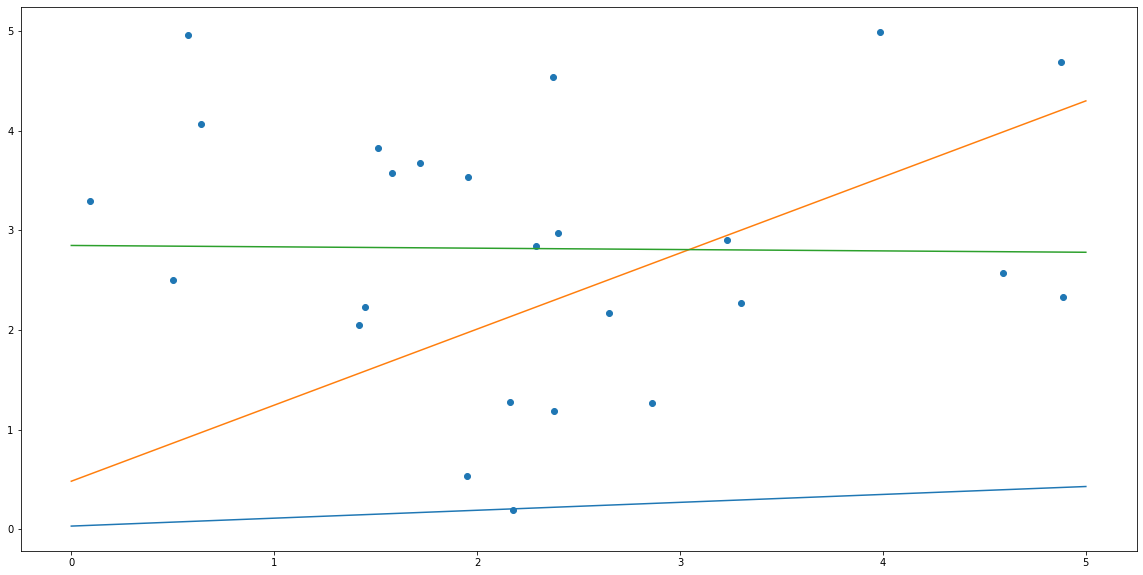

In [43]:
linear = Linear_Regression(0, 5, Mode.RANDOM_POINTS, False, 25)
lin_rate_test_list = np.arange(1e-4, 2e-4, 1e-4)
linear.test_stoch_grad(make_point(0, 0), lin_rate_test_list)
linear.test_minibatch(make_point(0, 0), lin_rate_test_list, max(2, linear.get_points_number() // 5))
linear.test_grad(make_point(0, 0), lin_rate_test_list)
linear.show()

green - GD  
orange - minibatch GD (5 summands)  
blue - SGD


,Linear rate,SGD distance,minibatch distance,GD distance,SGD epochs,minibatch epochs,GD epochs
0,0.00005,173.859095,48.431068,25.380035,950,6866,14707
1,0.00010,92.272703,28.479778,25.380035,454,8481,7353
2,0.00015,174.125829,28.864781,25.380035,316,6589,4901
3,0.00020,78.082743,29.902718,25.380034,248,3479,3676
4,0.00025,96.712465,25.802382,25.380035,309,6180,2940
5,0.00030,97.921678,25.739419,25.380034,157,3634,2450
6,0.00035,97.731257,25.424342,25.380033,283,3550,2100
7,0.00040,96.524009,25.850239,25.380035,246,4522,1837
8,0.00045,97.568526,25.423352,25.380033,122,3048,1633
9,0.00050,75.356977,29.239074,25.380031,559,3101,1470


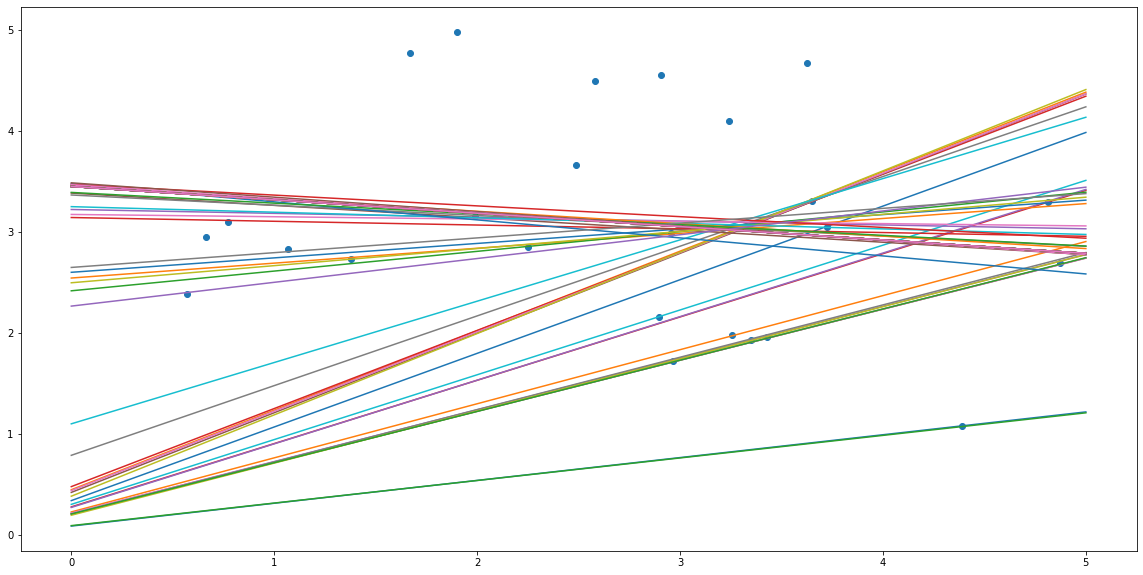

In [44]:
linear = Linear_Regression(0, 5, Mode.RANDOM_POINTS, False, 25)
lin_rate_test_list = np.arange(5e-5, 1e-3, 5e-5)
linear.get_table(make_point(0, 0), lin_rate_test_list, max(2, linear.get_points_number() // 5))

,Linear rate,SGD distance,minibatch distance,GD distance,SGD epochs,minibatch epochs,GD epochs
0,0.00005,0.716660,0.161080,0.000452,4990,5061,6466
1,0.00010,0.689563,0.199905,0.000452,2436,2575,3233
2,0.00015,0.623533,0.130200,0.000452,1720,2799,2155
3,0.00020,0.631475,0.265190,0.000452,1242,1831,1616
4,0.00025,0.562555,0.079388,0.000451,1069,1665,1293
5,0.00030,0.675362,0.169285,0.000452,941,1147,1077
6,0.00035,0.519350,0.066764,0.000449,748,1094,924
7,0.00040,0.610625,0.053859,0.000450,668,1043,808
8,0.00045,0.571647,0.085257,0.000451,600,1264,718
9,0.00050,0.722071,0.196494,0.000451,489,130,646


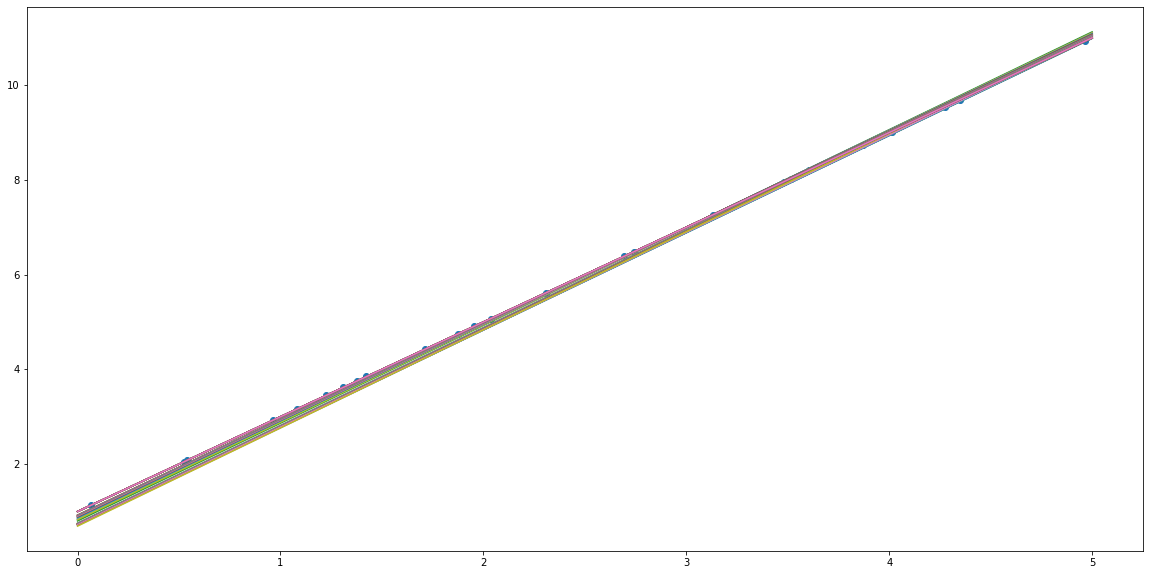

In [41]:
linear = Linear_Regression(0, 5, Mode.POINTS_ON_LINE, False, 25)
lin_rate_test_list = np.arange(5e-5, 1e-3, 5e-5)
linear.get_table(make_point(0, 0), lin_rate_test_list, max(2, linear.get_points_number() // 5))

<h5>Задание 2</h5>

,Linear rate,SGD distance,minibatch distance,GD distance,SGD epochs,minibatch epochs,GD epochs
0,0.00005,124.721158,0.564231,0.000100,34,7156,2806
1,0.00010,119.158800,0.805849,0.000099,51,3191,1402
2,0.00015,124.241396,0.157517,0.000099,1,2357,934
3,0.00020,124.741858,0.036761,0.000099,27,1368,700
4,0.00025,125.000000,0.229761,0.000098,43,1527,560
5,0.00030,117.253254,0.168876,0.000098,11,1067,466
6,0.00035,117.244548,0.057015,0.000099,33,1166,399
7,0.00040,120.152285,0.254555,0.000098,114,410,349
8,0.00045,120.693727,0.026577,0.000098,5,896,310
9,0.00050,123.302893,0.462163,0.000096,2,824,279


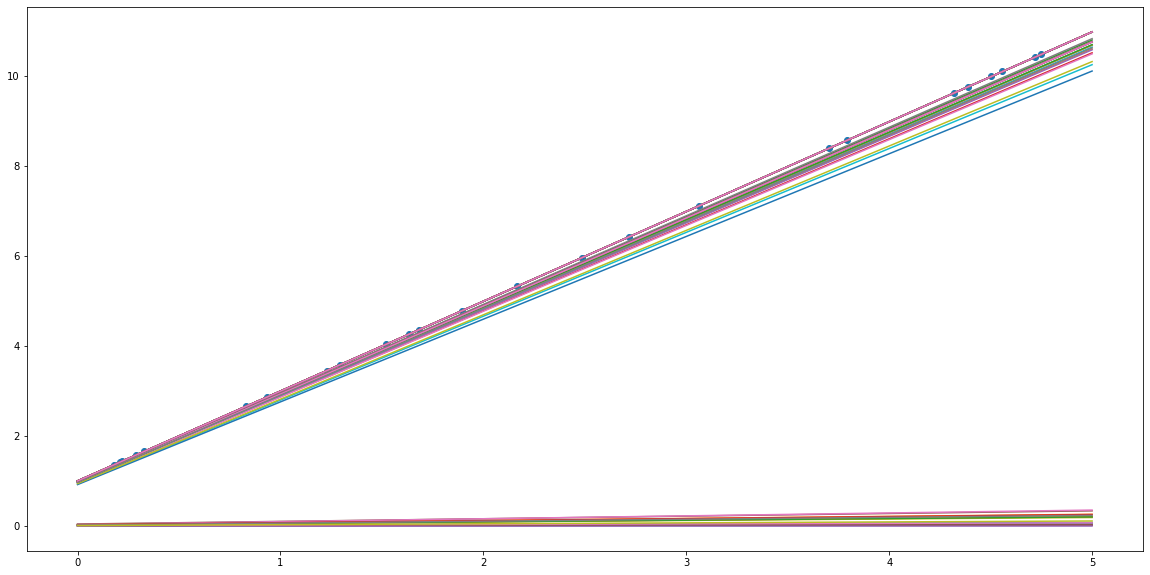

In [55]:
linear = Linear_Regression(0, 5, Mode.POINTS_ON_LINE, True, 25)
lin_rate_test_list = np.arange(5e-5, 1e-3, 5e-5)
linear.get_table(make_point(0, 0), lin_rate_test_list, max(2, linear.get_points_number() // 5))

,Linear rate,SGD distance,minibatch distance,GD distance,SGD epochs,minibatch epochs,GD epochs
0,0.00005,201.289784,61.034499,57.778212,1083,18701,2878
1,0.00010,195.733569,57.779713,57.778211,545,1750,1438
2,0.00015,198.269233,57.785064,57.778211,349,6180,958
3,0.00020,201.826643,57.851162,57.778211,250,29148,718
4,0.00025,191.323714,57.808752,57.778210,222,2020,574
5,0.00030,200.537301,57.804830,57.778210,216,1439,478
6,0.00035,195.319911,57.798197,57.778211,315,7737,409
7,0.00040,200.931333,57.786839,57.778209,222,672,358
8,0.00045,187.342052,57.947982,57.778209,160,22120,318
9,0.00050,198.761796,57.861562,57.778209,105,654,286


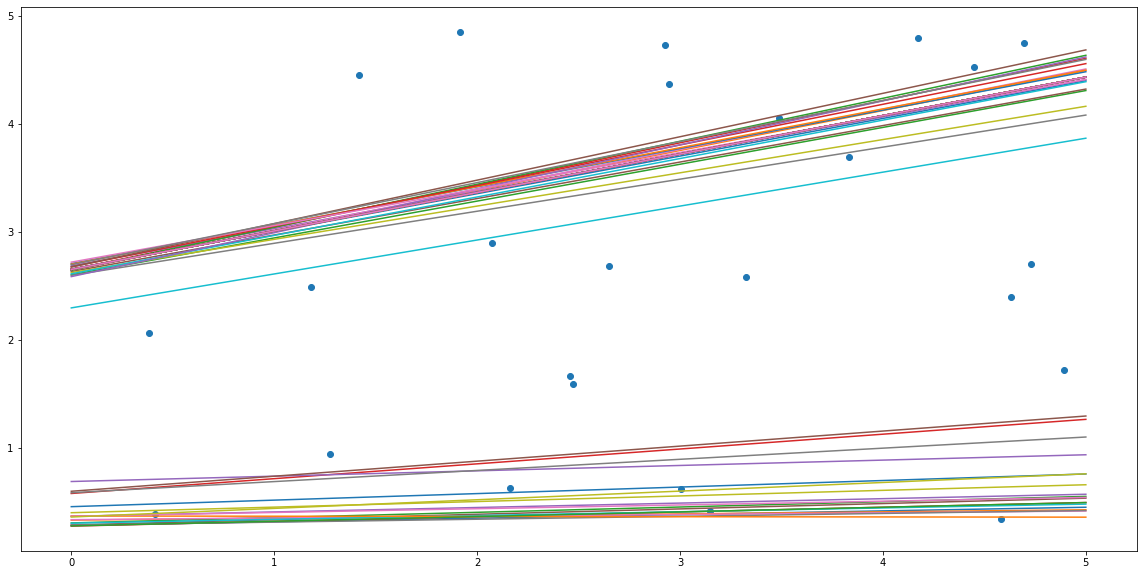

In [56]:
linear = Linear_Regression(0, 5, Mode.RANDOM_POINTS, True, 25)
lin_rate_test_list = np.arange(5e-5, 1e-3, 5e-5)
linear.get_table(make_point(0, 0), lin_rate_test_list, max(2, linear.get_points_number() // 5))